In [6]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'sklearn'

In [2]:
from src.model.modelGranoGan import Encoder,Decoder,Critic
from src.utils.losses import Wasserstein
from src.utils.util import *
from src.dataset.swat import SwatDataset
from src.algorithms.GranoGAN import GranoGAN

In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    

01:48:07


In [4]:
seed=0
swat = SwatDataset(seed)

In [5]:
x_train, y_train, x_test, y_test = swat.data()

/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:142: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df: pd.DataFrame = pd.read_csv(self.raw_path_test)
/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:143: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df: pd.DataFrame = pd.read_csv(self.raw_path_train)


Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 19271
% of anomalies in the test set = 4.6484421169937935
number of anomalous events = 35


In [6]:
print(x_train.shape)

(495000, 51)


In [23]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [24]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [25]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [7]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [8]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [9]:
reduced_dimesnion=51
window_length=60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [10]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)

In [11]:
granoGAN=GranoGAN(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,in_dim=in_dim)

In [ ]:
criticX=granoGAN.train_criticX(train_loader)

/home/jupyter/GRANOGAN-IISC/src/algorithms/GranoGAN.py:110: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


Epoch 0: train loss -1.9953852315702696
Epoch 1: train loss -1.9999820342891643


In [12]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/swat/criticX.pkl'


In [ ]:
torch.save(criticX.module.state_dict(), PATH)

In [13]:
criticX=Critic(in_dim=in_dim,device=device)
criticX=nn.DataParallel(criticX)
criticX.to(device)
state_dict = torch.load(PATH)
criticX=granoGAN.load_model(state_dict,criticX)

In [14]:
granoGAN.initialize_criticX(criticX)

In [ ]:
criticZ=granoGAN.train_criticZ(train_loader)

In [15]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/swat/criticZ.pkl'


In [ ]:
torch.save(criticZ.module.state_dict(), PATH)

In [16]:
criticZ=Critic(in_dim=in_dim,device=device)
criticZ=nn.DataParallel(criticZ)
criticZ.to(device)
state_dict = torch.load(PATH)
criticZ=granoGAN.load_model(state_dict,criticZ)

In [17]:
granoGAN.initialize_criticZ(criticZ)

In [ ]:
encoder,decoder=granoGAN.train_enc_dec(train_loader)

/home/jupyter/GRANOGAN-IISC/src/algorithms/GranoGAN.py:173: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=self.mean,std=self.std))


In [ ]:
PATH_encoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/swat/encoder.pkl'

PATH_decoder='/home/jupyter/GRANOGAN-IISC/src/saved_models/granogan/swat/decoder.pkl'

In [ ]:
torch.save(encoder.module.state_dict(), PATH_encoder)
torch.save(decoder.module.state_dict(), PATH_decoder)

In [ ]:
encoder=Encoder(n_features=in_dim, embedding_dim=in_dim,device=device)
encoder=nn.DataParallel(encoder)
encoder.to(device)
state_dict = torch.load(PATH_encoder)
encoder=granoGAN.load_model(state_dict,encoder)

In [ ]:
decoder=Decoder(in_dim=in_dim,out_dim=in_dim,device=device)
decoder=nn.DataParallel(decoder)
decoder.to(device)
state_dict = torch.load(PATH_decoder)
decoder=granoGAN.load_model(state_dict,decoder)

In [ ]:
granoGAN.initialize_decoder(decoder)
granoGAN.initialize_encoder(encoder)

In [ ]:
granoGAN.initialize_models(criticX,criticZ,decoder,encoder)

In [ ]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [ ]:
losses=granoGAN.predict_loss(test_loader)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

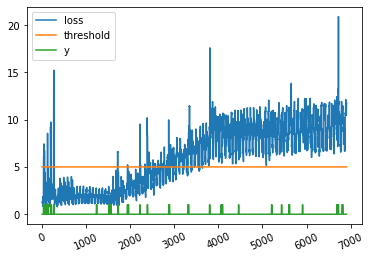

In [74]:
THRESHOLD =5

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

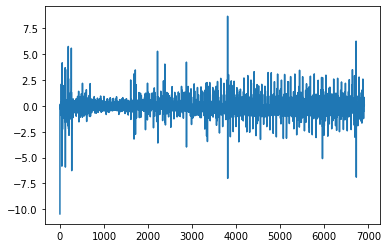

In [82]:
diff = list()
for i in range(0, len(losses)):
    value = losses[i]/60 - losses[i - 1]/60
    diff.append(value)
plt.plot(diff)
plt.show()

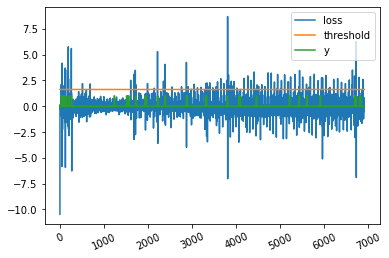

In [145]:
THRESHOLD =1.62

test_score_df = pd.DataFrame(index=range(len(diff)))
test_score_df['loss'] = [loss for loss in diff]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [146]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [147]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 217
True Negative	 6455
False Positive	 97
False Negative	 140
Accuracy	 0.9656969170646982
Precision	 0.6910828025477707
Recall	 0.6078431372549019
f-measure	 0.6467958271236959
cohen_kappa_score	 0.6288466939257341
auc	 0.7965192487251311
roc_auc	 0.7965192487251311
